# Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import graphviz
from sklearn.tree import export_graphviz, export_text
import random

seed = 1221
np.random.seed(seed)
random.seed(seed)

# Data Preprocessing & Visualization

In [2]:
train_df = pd.read_csv('./training_set.csv')
test_df = pd.read_csv('./test_set.csv')

In [3]:
print(f'train shape: {train_df.shape}')
train_df.head()

train shape: (92, 8)


,Impurity.Percent,Impurity.Type,I,II,III,IV,V,Temp
0,2.69,A,103.9,14.4,9.5,5.0,49.9,31.42
1,3.15,A,105.5,14.6,9.7,5.0,50.1,33.51
2,3.24,A,106.1,14.6,9.7,5.0,50.0,35.45
3,3.32,A,108.5,14.6,9.6,4.9,50.1,32.60
4,3.56,A,107.1,14.4,9.3,5.0,48.6,30.53


In [4]:
print(f'test shape: {test_df.shape}')
test_df.head()

test shape: (100, 6)


,I,II,III,IV,V,Temp
0,99.0,14.3,9.7,18.4,49.5,29.17
1,96.5,13.3,9.6,32.8,49.4,29.29
2,99.1,15.2,9.9,6.8,54.5,34.65
3,97.4,14.1,9.2,25.3,48.7,35.81
4,99.8,20.4,9.8,5.7,64.6,34.39


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Impurity.Percent  92 non-null     float64
 1   Impurity.Type     92 non-null     object 
 2   I                 92 non-null     float64
 3   II                92 non-null     float64
 4   III               92 non-null     float64
 5   IV                92 non-null     float64
 6   V                 92 non-null     float64
 7   Temp              92 non-null     float64
dtypes: float64(7), object(1)
memory usage: 5.9+ KB


In [6]:
train_df.describe()

,Impurity.Percent,I,II,III,IV,V,Temp
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,4.031739,99.809783,16.407609,13.075000,10.204348,54.901087,31.118696
std,1.776082,2.695257,3.368511,11.277281,7.157305,6.555335,2.723605
min,1.860000,95.900000,12.800000,8.800000,4.900000,47.000000,23.620000
25%,2.697500,98.500000,14.475000,9.575000,5.700000,49.000000,29.052500
50%,3.460000,99.300000,14.800000,9.800000,7.450000,53.650000,31.655000
75%,4.995000,100.100000,17.325000,10.300000,10.175000,59.600000,33.147500
max,7.940000,110.300000,29.100000,67.500000,34.700000,75.600000,35.530000


In [4]:
train_df = train_df.drop(['Impurity.Percent'], axis=1)
train_df.head()

,Impurity.Type,I,II,III,IV,V,Temp
0,A,103.9,14.4,9.5,5.0,49.9,31.42
1,A,105.5,14.6,9.7,5.0,50.1,33.51
2,A,106.1,14.6,9.7,5.0,50.0,35.45
3,A,108.5,14.6,9.6,4.9,50.1,32.60
4,A,107.1,14.4,9.3,5.0,48.6,30.53


In [5]:
features_list = train_df.columns[1:]
features = train_df[features_list]
y = train_df['Impurity.Type']
label_names = y.unique()
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f'features shape: {features.shape}')
print(f'features: {features_list}')
print(f'labels: {label_names}')
print(f'labels encoded: {np.unique(y_encoded)}')

features shape: (92, 6)
features: Index(['I', 'II', 'III', 'IV', 'V', 'Temp'], dtype='object')
labels: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K' 'L' 'M' 'N']
labels encoded: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


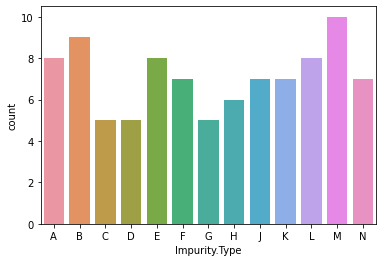

In [9]:
# data counplot 
sns.countplot(x='Impurity.Type', data=train_df)
plt.show()

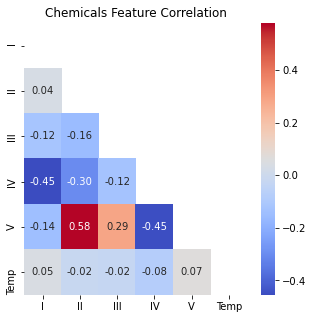

In [10]:
# Correlation Matrix
corrMatrix = features.corr()
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
fig, axs = plt.subplots(figsize=(5, 5))
plt.title('Chemicals Feature Correlation')
sns.heatmap(corrMatrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

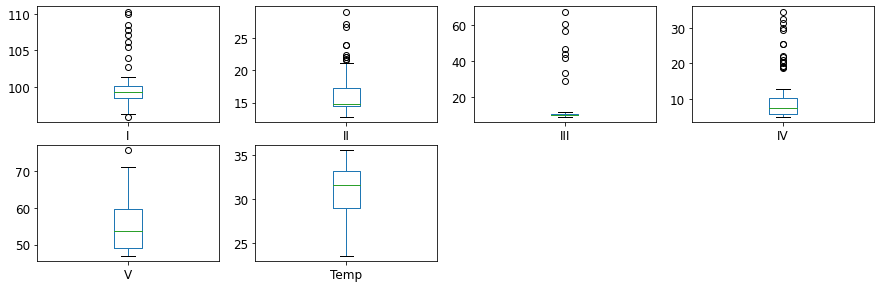

In [23]:
# box plot to check the value range and outliers of each feature
features.plot(kind='box', subplots=True, layout=(8,4), sharex=False, sharey=False, fontsize=12, figsize=(15,20), xlabel='Features')
plt.show()


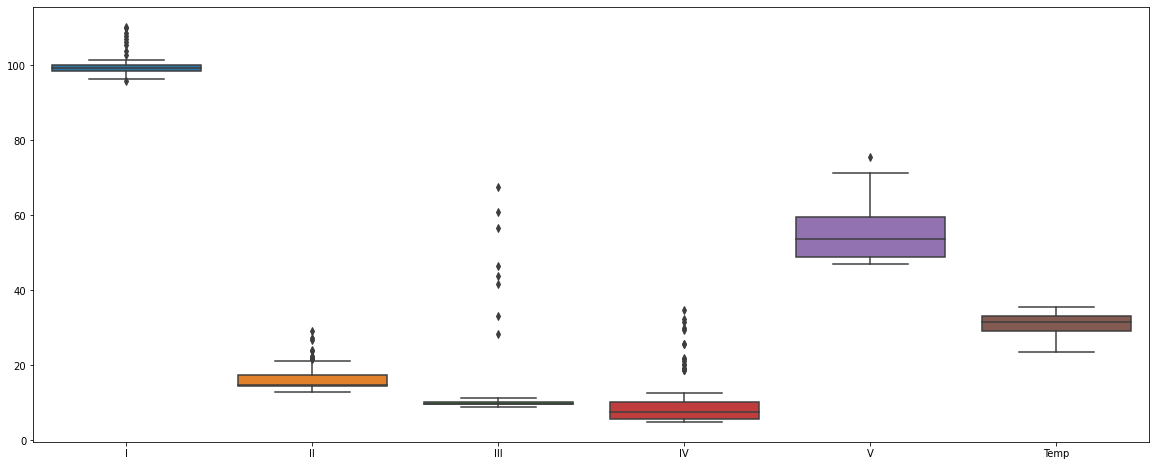

In [13]:
# Compare the features data ranges.
fig, ax = plt.subplots(1, figsize=(20, 8))
sns.boxplot(data=features, ax=ax)
plt.show()

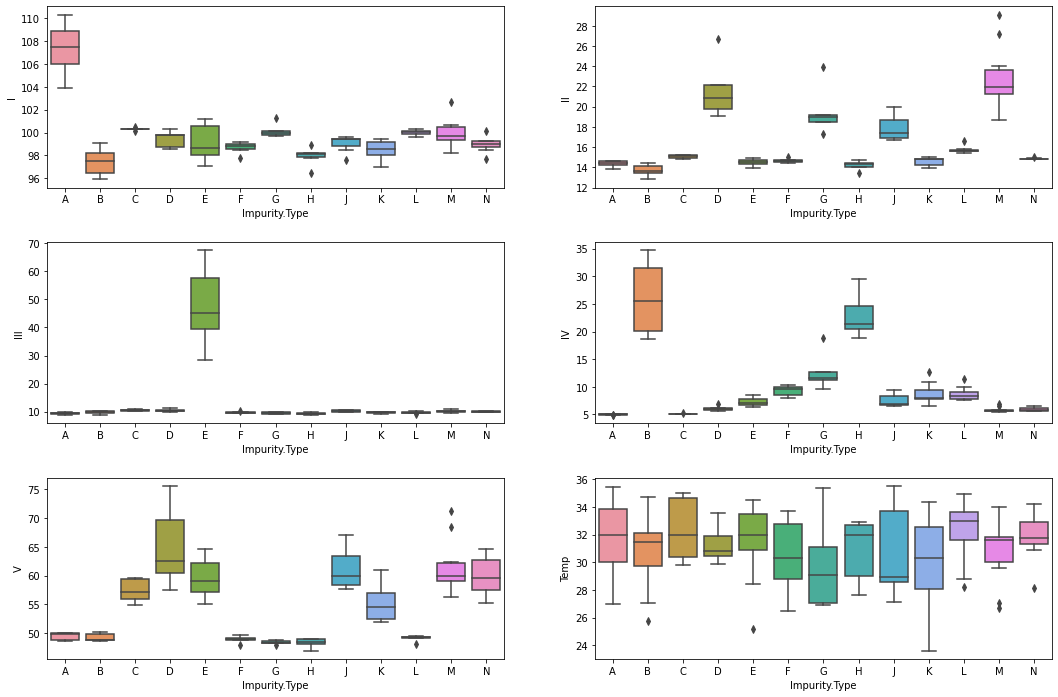

In [90]:
# Use boxplots to see if certain feature can discriminate between labels
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.ravel()
for i, column in enumerate(features):
    sns.boxplot(x='Impurity.Type', y=column, data=train_df, ax=axs[i])

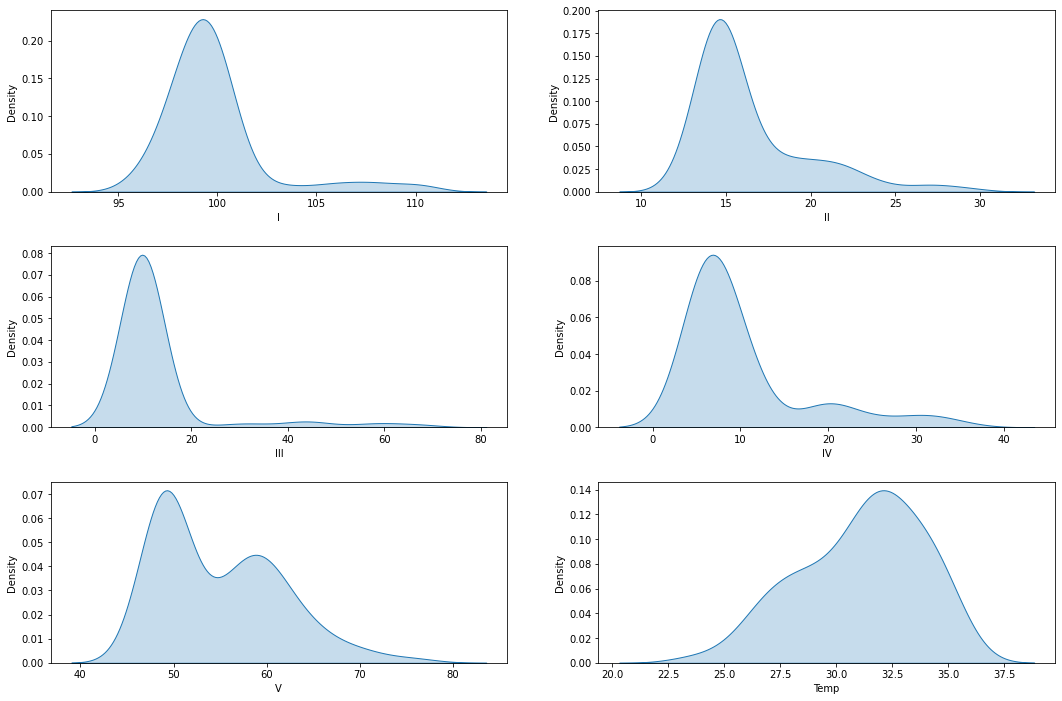

In [9]:
# Plot density function of each feature without label
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.ravel()
for i, column in enumerate(features):
    sns.kdeplot(data=train_df[column], ax=axs[i], shade=True)

plt.show()

In [51]:
# check value of feature III in test set
test_df[test_df.III > 15]

,I,II,III,IV,V,Temp
36,101.0,14.3,37.7,7.2,55.9,24.08
50,100.3,14.8,39.7,7.0,57.5,26.60
72,98.3,14.5,46.7,6.9,58.4,33.93
94,97.8,14.0,60.7,8.0,60.1,27.30
97,97.0,13.7,68.5,7.8,62.2,28.78
99,101.0,14.1,64.3,8.4,64.3,28.90


In [50]:
# check value of feature III in train set
train_df[train_df.III > 15]

,Impurity.Type,I,II,III,IV,V,Temp
27,E,100.5,14.7,28.5,6.3,55.1,34.42
28,E,100.7,14.7,33.2,6.8,56.7,31.79
29,E,99.0,14.5,41.7,6.8,58.0,32.20
30,E,98.3,14.6,43.7,6.7,57.3,31.68
31,E,101.2,14.4,46.6,7.2,60.1,33.14
32,E,98.1,14.0,56.6,8.5,61.5,28.42
33,E,97.1,14.9,60.8,7.6,64.7,34.51
34,E,98.0,13.9,67.5,8.5,64.4,25.17


In [ ]:
# sns.pairplot(data=train_df, hue='Impurity.Type', vars=['I', 'II', 'III', 'IV', 'V'])
# plt.show()

# Helper Functions

In [6]:
# Display results functions
def display_results(y_val, y_prediction, labels, score, model_name):
    cm = confusion_matrix(y_val, y_prediction, labels = labels) 
    disp = ConfusionMatrixDisplay(cm, display_labels = labels)
    disp.plot(cmap=plt.cm.Blues,values_format='g')
    disp.ax_.set_title(f'Model: {model_name}, Accuracy: {score:.3f}')
    plt.show()

    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)


    print(classification_report(y_val, y_prediction, zero_division=0))
    print(f'FP: {np.sum(FP)}, FN: {np.sum(FN)}, avg_FP+FN; {(np.sum(FP)+np.sum(FN))/2}')
    return {'FP': np.sum(FP), 'FN': np.sum(FN), 'avg_FP_FN': (np.sum(FP)+np.sum(FN))/2, 'accuracy_score': np.round(score, 2)}

In [7]:
# Cross Validation Function
def cross_validation(model, X, labels, label_names, n_folds, model_name, seed=1221):
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    # pipeline = Pipeline([('model', model)])
    scores = cross_val_score(pipeline, X, labels, cv=cv, scoring='accuracy')
    print(f'Accuracy: {scores.mean():.3f} +/- {scores.std():.3f}')
    y_pred = cross_val_predict(pipeline, X, labels, cv=cv)

    res = display_results(labels, y_pred, label_names, scores.mean(), model_name)

    return res

# Basic Classification

In [26]:
results = {}

## Logistic Regression

Accuracy: 0.684 +/- 0.075


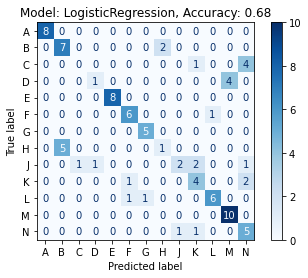

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.58      0.78      0.67         9
           C       0.00      0.00      0.00         5
           D       0.50      0.20      0.29         5
           E       1.00      1.00      1.00         8
           F       0.75      0.86      0.80         7
           G       0.83      1.00      0.91         5
           H       0.33      0.17      0.22         6
           J       0.67      0.29      0.40         7
           K       0.50      0.57      0.53         7
           L       0.86      0.75      0.80         8
           M       0.71      1.00      0.83        10
           N       0.42      0.71      0.53         7

    accuracy                           0.68        92
   macro avg       0.63      0.64      0.61        92
weighted avg       0.65      0.68      0.65        92

FP: 29, FN: 29, avg_FP+FN; 29.0


In [93]:
clf = LogisticRegression(random_state=seed)
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='LogisticRegression', seed=seed)
results['LogisticRegression'] = res

## SVM

Accuracy: 0.589 +/- 0.101


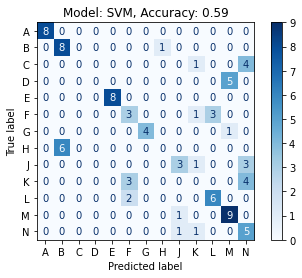

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.57      0.89      0.70         9
           C       0.00      0.00      0.00         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       0.38      0.43      0.40         7
           G       1.00      0.80      0.89         5
           H       0.00      0.00      0.00         6
           J       0.60      0.43      0.50         7
           K       0.00      0.00      0.00         7
           L       0.67      0.75      0.71         8
           M       0.60      0.90      0.72        10
           N       0.31      0.71      0.43         7

    accuracy                           0.59        92
   macro avg       0.47      0.53      0.49        92
weighted avg       0.51      0.59      0.53        92

FP: 38, FN: 38, avg_FP+FN; 38.0


In [20]:
clf = SVC(random_state=seed)
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='SVM', seed=seed)
results['SVM'] = res

## Decision Tree

Accuracy: 0.739 +/- 0.075


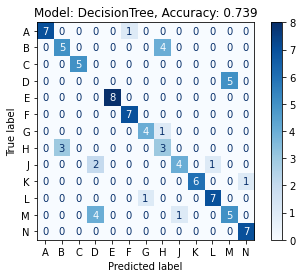

              precision    recall  f1-score   support

           A       1.00      0.88      0.93         8
           B       0.62      0.56      0.59         9
           C       1.00      1.00      1.00         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       0.88      1.00      0.93         7
           G       0.80      0.80      0.80         5
           H       0.38      0.50      0.43         6
           J       0.80      0.57      0.67         7
           K       1.00      0.86      0.92         7
           L       0.88      0.88      0.88         8
           M       0.50      0.50      0.50        10
           N       0.88      1.00      0.93         7

    accuracy                           0.74        92
   macro avg       0.75      0.73      0.74        92
weighted avg       0.76      0.74      0.74        92

FP: 24, FN: 24, avg_FP+FN; 24.0


In [28]:
clf = DecisionTreeClassifier(random_state=seed)
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='DecisionTree', seed=seed)
results['DecisionTree'] = res

## Naive Bayes

Accuracy: 0.773 +/- 0.070


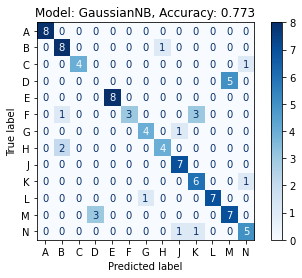

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.73      0.89      0.80         9
           C       1.00      0.80      0.89         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       1.00      0.43      0.60         7
           G       0.80      0.80      0.80         5
           H       0.80      0.67      0.73         6
           J       0.78      1.00      0.88         7
           K       0.60      0.86      0.71         7
           L       1.00      0.88      0.93         8
           M       0.58      0.70      0.64        10
           N       0.71      0.71      0.71         7

    accuracy                           0.77        92
   macro avg       0.77      0.75      0.74        92
weighted avg       0.78      0.77      0.76        92

FP: 21, FN: 21, avg_FP+FN; 21.0


In [29]:
clf = GaussianNB()
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='GaussianNB', seed=seed)
results['GaussianNB'] = res

## KNN

Accuracy: 0.577 +/- 0.131


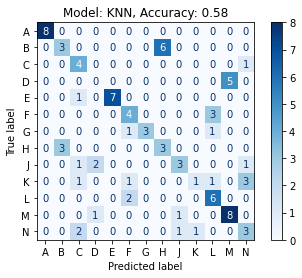

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.50      0.33      0.40         9
           C       0.44      0.80      0.57         5
           D       0.00      0.00      0.00         5
           E       1.00      0.88      0.93         8
           F       0.50      0.57      0.53         7
           G       1.00      0.60      0.75         5
           H       0.33      0.50      0.40         6
           J       0.60      0.43      0.50         7
           K       0.50      0.14      0.22         7
           L       0.55      0.75      0.63         8
           M       0.62      0.80      0.70        10
           N       0.38      0.43      0.40         7

    accuracy                           0.58        92
   macro avg       0.57      0.56      0.54        92
weighted avg       0.59      0.58      0.56        92

FP: 39, FN: 39, avg_FP+FN; 39.0


In [97]:
clf = KNeighborsClassifier()
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='KNN', seed=seed)
results['KNN'] = res

## Random Forest

Accuracy: 0.816 +/- 0.053


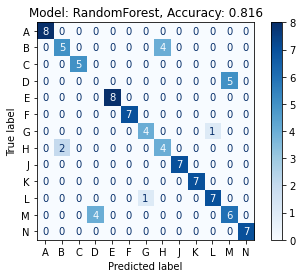

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.71      0.56      0.63         9
           C       1.00      1.00      1.00         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       1.00      1.00      1.00         7
           G       0.80      0.80      0.80         5
           H       0.50      0.67      0.57         6
           J       1.00      1.00      1.00         7
           K       1.00      1.00      1.00         7
           L       0.88      0.88      0.88         8
           M       0.55      0.60      0.57        10
           N       1.00      1.00      1.00         7

    accuracy                           0.82        92
   macro avg       0.80      0.81      0.80        92
weighted avg       0.81      0.82      0.81        92

FP: 17, FN: 17, avg_FP+FN; 17.0


In [30]:
clf = RandomForestClassifier(random_state=seed)
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='RandomForest', seed=seed)
results['RandomForest'] = res

## LDA

Accuracy: 0.729 +/- 0.185


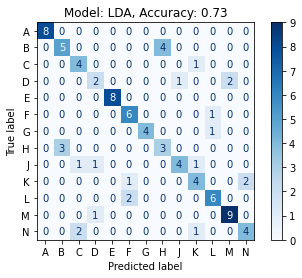

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.62      0.56      0.59         9
           C       0.57      0.80      0.67         5
           D       0.50      0.40      0.44         5
           E       1.00      1.00      1.00         8
           F       0.67      0.86      0.75         7
           G       1.00      0.80      0.89         5
           H       0.43      0.50      0.46         6
           J       0.80      0.57      0.67         7
           K       0.57      0.57      0.57         7
           L       0.75      0.75      0.75         8
           M       0.82      0.90      0.86        10
           N       0.67      0.57      0.62         7

    accuracy                           0.73        92
   macro avg       0.72      0.71      0.71        92
weighted avg       0.74      0.73      0.73        92

FP: 25, FN: 25, avg_FP+FN; 25.0


In [21]:
clf = LinearDiscriminantAnalysis()
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='LDA', seed=seed)
results['LDA'] = res

## QDA  

/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are col

Accuracy: 0.227 +/- 0.076


/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


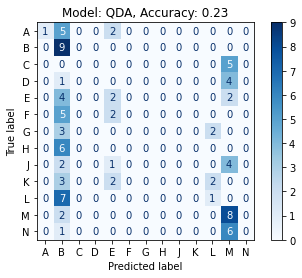

              precision    recall  f1-score   support

           A       1.00      0.12      0.22         8
           B       0.19      1.00      0.32         9
           C       0.00      0.00      0.00         5
           D       0.00      0.00      0.00         5
           E       0.22      0.25      0.24         8
           F       0.00      0.00      0.00         7
           G       0.00      0.00      0.00         5
           H       0.00      0.00      0.00         6
           J       0.00      0.00      0.00         7
           K       0.00      0.00      0.00         7
           L       0.20      0.12      0.15         8
           M       0.28      0.80      0.41        10
           N       0.00      0.00      0.00         7

    accuracy                           0.23        92
   macro avg       0.15      0.18      0.10        92
weighted avg       0.17      0.23      0.13        92

FP: 71, FN: 71, avg_FP+FN; 71.0


In [100]:
clf = QuadraticDiscriminantAnalysis()
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='QDA', seed=seed)
results['QDA'] = res

## Gradient Boosting

Accuracy: 0.685 +/- 0.098


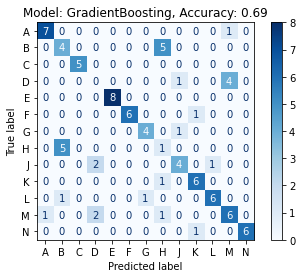

              precision    recall  f1-score   support

           A       0.88      0.88      0.88         8
           B       0.40      0.44      0.42         9
           C       1.00      1.00      1.00         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       1.00      0.86      0.92         7
           G       0.80      0.80      0.80         5
           H       0.12      0.17      0.14         6
           J       0.67      0.57      0.62         7
           K       0.75      0.86      0.80         7
           L       0.86      0.75      0.80         8
           M       0.55      0.60      0.57        10
           N       1.00      0.86      0.92         7

    accuracy                           0.68        92
   macro avg       0.69      0.68      0.68        92
weighted avg       0.70      0.68      0.69        92

FP: 29, FN: 29, avg_FP+FN; 29.0


In [37]:
clf = GradientBoostingClassifier(random_state=seed)
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='GradientBoosting', seed=seed)
results['GradientBoosting'] = res

## SGDClassifier

Accuracy: 0.577 +/- 0.118


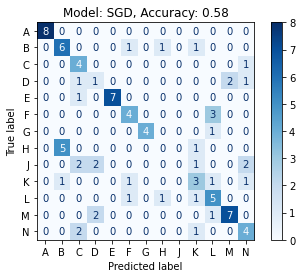

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.50      0.67      0.57         9
           C       0.40      0.80      0.53         5
           D       0.20      0.20      0.20         5
           E       1.00      0.88      0.93         8
           F       0.57      0.57      0.57         7
           G       1.00      0.80      0.89         5
           H       0.00      0.00      0.00         6
           J       0.00      0.00      0.00         7
           K       0.38      0.43      0.40         7
           L       0.45      0.62      0.53         8
           M       0.78      0.70      0.74        10
           N       0.44      0.57      0.50         7

    accuracy                           0.58        92
   macro avg       0.52      0.56      0.53        92
weighted avg       0.54      0.58      0.55        92

FP: 39, FN: 39, avg_FP+FN; 39.0


In [39]:
clf = SGDClassifier(random_state=seed)
res = cross_validation(model=clf, X=features, labels=y, label_names= label_names, n_folds=5, model_name='SGD', seed=seed)
results['SGD'] = res

## XGBoost

Accuracy: 0.727 +/- 0.095


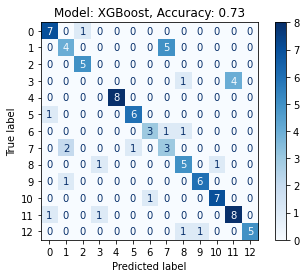

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.57      0.44      0.50         9
           2       0.83      1.00      0.91         5
           3       0.00      0.00      0.00         5
           4       1.00      1.00      1.00         8
           5       0.86      0.86      0.86         7
           6       0.75      0.60      0.67         5
           7       0.33      0.50      0.40         6
           8       0.62      0.71      0.67         7
           9       0.86      0.86      0.86         7
          10       0.88      0.88      0.88         8
          11       0.67      0.80      0.73        10
          12       1.00      0.71      0.83         7

    accuracy                           0.73        92
   macro avg       0.70      0.71      0.70        92
weighted avg       0.72      0.73      0.72        92

FP: 25, FN: 25, avg_FP+FN; 25.0


In [108]:
clf = XGBClassifier(random_state=seed)
res = cross_validation(model=clf, X=features, labels=y_encoded, label_names= None, n_folds=5, model_name='XGBoost', seed=seed)
results['XGBoost'] = res

## Distance Calculation

In [98]:
train_avg = train_df.groupby('Impurity.Type').mean()
distances = cdist(test_df, train_avg, metric='euclidean')
closest = np.argmin(distances, axis=1)
closest_labels = train_avg.index[closest]
closest_labels = pd.DataFrame(closest_labels)

clf = RandomForestClassifier(random_state=seed)
pipeline = Pipeline([('scaler', StandardScaler()), ('model', clf)])
pipeline.fit(features, y)
y_pred = pipeline.predict(test_df)
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

y_pred['closest_label'] = closest_labels

y_pred.head()

,y_pred,closest_label
0,B,H
1,B,B
2,K,C
3,H,B
4,M,D


In [123]:
# Type A
print(f'Type A, Feature I, min: {train_df[train_df["Impurity.Type"] == "A"]["I"].min()}, max: {train_df[train_df["Impurity.Type"] == "A"]["I"].max()}')
print(f"Prediction of Type A: \n{test_df[y_pred['y_pred'] == 'A']}")
print()

# Type E
print(f'Type E, Feature III, min: {train_df[train_df["Impurity.Type"] == "E"]["III"].min()}, max: {train_df[train_df["Impurity.Type"] == "E"]["III"].max()}')
print(f"Prediction of Type E: \n{test_df[y_pred['y_pred'] == 'E']}")
print()

# Type B and H
print(f'Type B, Feature IV, min: {train_df[train_df["Impurity.Type"] == "B"]["IV"].min()}, max: {train_df[train_df["Impurity.Type"] == "B"]["IV"].max()}')
print(f"Prediction of Type B: \n{test_df[y_pred['y_pred'] == 'B']}")
print()

print(f'Type H, Feature IV, min: {train_df[train_df["Impurity.Type"] == "H"]["IV"].min()}, max: {train_df[train_df["Impurity.Type"] == "H"]["IV"].max()}')
print(f"Prediction of Type H: \n{test_df[y_pred['y_pred'] == 'H']}")
print()



Type A, Feature I, min: 103.9, max: 110.3
Prediction of Type A: 
        I    II   III   IV     V   Temp
5   100.3  15.2  10.0  5.1  50.8  34.90
25  101.3  15.0   9.6  5.1  51.1  33.84
28   99.7  15.1   9.8  5.2  50.1  29.14
29  105.3  14.4   9.7  5.0  49.6  33.29
34   99.8  15.1   9.8  5.2  50.7  31.18
56   99.6  15.1   9.7  5.3  50.0  27.14
63  102.7  15.2   9.5  5.3  50.1  29.04
95  103.6  14.6   9.7  4.8  50.0  35.05

Type E, Feature III, min: 28.5, max: 67.5
Prediction of Type E: 
        I    II   III   IV     V   Temp
36  101.0  14.3  37.7  7.2  55.9  24.08
50  100.3  14.8  39.7  7.0  57.5  26.60
72   98.3  14.5  46.7  6.9  58.4  33.93
94   97.8  14.0  60.7  8.0  60.1  27.30
97   97.0  13.7  68.5  7.8  62.2  28.78
99  101.0  14.1  64.3  8.4  64.3  28.90

Type B, Feature IV, min: 18.7, max: 34.7
Prediction of Type B: 
       I    II  III    IV     V   Temp
0   99.0  14.3  9.7  18.4  49.5  29.17
1   96.5  13.3  9.6  32.8  49.4  29.29
20  97.3  14.1  9.2  23.0  50.1  32.87
35  94.7

## Plot the results

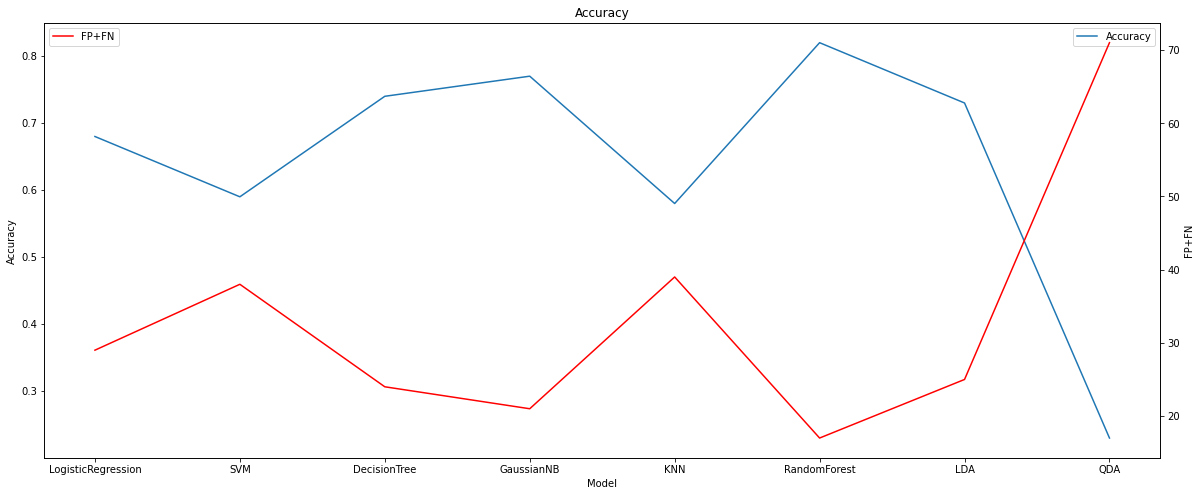

In [101]:
# Plot the results
models = results.keys()
acc = [results[model]['accuracy_score'] for model in models]
avg_fp_fn = [results[model]['avg_FP_FN'] for model in models]

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(models, acc, label='Accuracy')
ax.title.set_text('Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.legend()

ax2 = ax.twinx()
ax2.plot(models, avg_fp_fn, color='red', label='FP+FN')
ax2.set_ylabel('FP+FN')
ax2.legend()

plt.show()

# Dimension Reduction

## PCA

In [17]:
pca = PCA()
X_pca = pca.fit_transform(features)
print(f'X_pca shape: {X_pca.shape}')

X_pca shape: (92, 6)


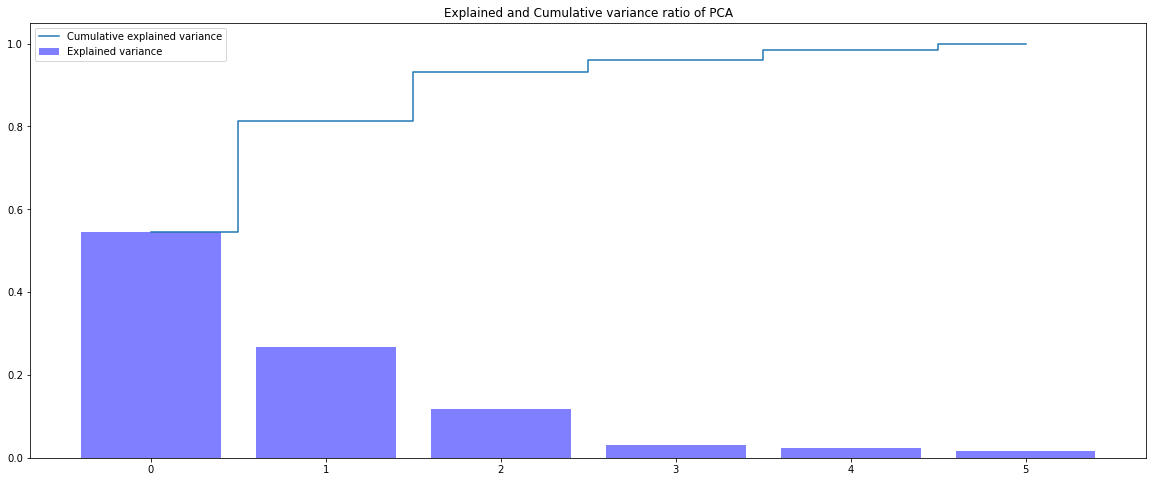

In [18]:
# Plot the explained variance and the cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig, ax = plt.subplots(1, figsize=(20, 8))
plt.title('Explained and Cumulative variance ratio of PCA')
plt.bar(np.arange(0, len(explained_variance)), explained_variance, color='blue', alpha=0.5, align='center', label='individual explained variance')
plt.step(np.arange(0, len(cumulative_explained_variance)), cumulative_explained_variance, where='mid', label='cumulative explained variance')
plt.legend(['Cumulative explained variance', 'Explained variance'])
plt.show()

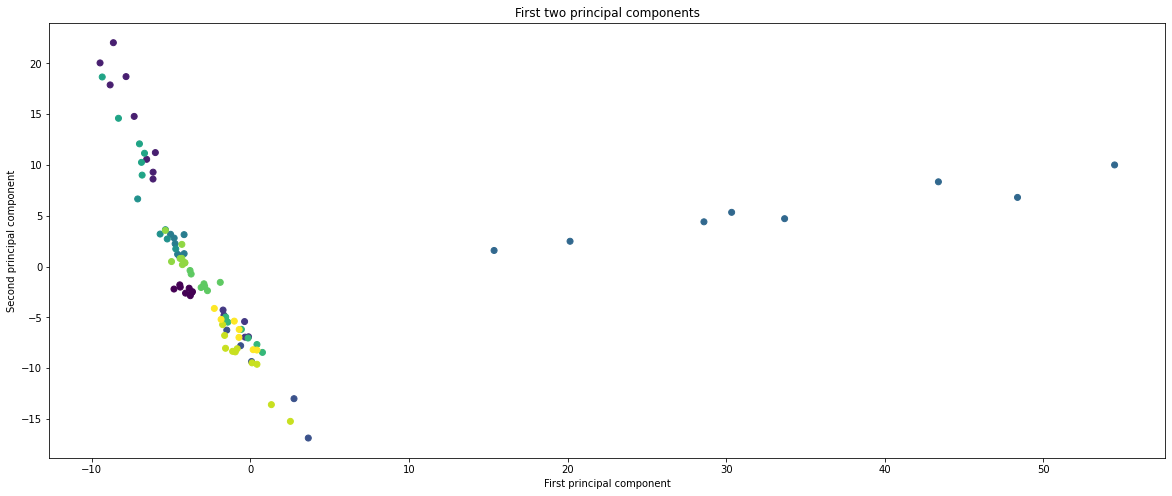

In [23]:
fig, ax = plt.subplots(1, figsize=(20, 8))
plt.title('First two principal components')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

In [24]:
X_pca = X_pca[:, :3]
print(f'X_pca shape: {X_pca.shape}')

X_pca shape: (92, 3)


## Training in the reduced space

In [25]:
results = {}

## Logistic Regression

Accuracy: 0.501 +/- 0.057


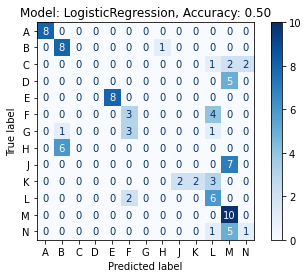

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.53      0.89      0.67         9
           C       0.00      0.00      0.00         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       0.38      0.43      0.40         7
           G       0.00      0.00      0.00         5
           H       0.00      0.00      0.00         6
           J       0.00      0.00      0.00         7
           K       1.00      0.29      0.44         7
           L       0.38      0.75      0.50         8
           M       0.34      1.00      0.51        10
           N       0.33      0.14      0.20         7

    accuracy                           0.50        92
   macro avg       0.38      0.42      0.36        92
weighted avg       0.43      0.50      0.42        92

FP: 46, FN: 46, avg_FP+FN; 46.0


In [26]:
clf = LogisticRegression(random_state=seed)
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='LogisticRegression', seed=seed)
results['LogisticRegression'] = res

## SVM

Accuracy: 0.490 +/- 0.073


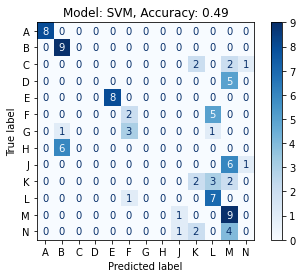

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.56      1.00      0.72         9
           C       0.00      0.00      0.00         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       0.33      0.29      0.31         7
           G       0.00      0.00      0.00         5
           H       0.00      0.00      0.00         6
           J       0.00      0.00      0.00         7
           K       0.33      0.29      0.31         7
           L       0.44      0.88      0.58         8
           M       0.32      0.90      0.47        10
           N       0.00      0.00      0.00         7

    accuracy                           0.49        92
   macro avg       0.31      0.41      0.34        92
weighted avg       0.35      0.49      0.39        92

FP: 47, FN: 47, avg_FP+FN; 47.0


In [27]:
from sklearn.svm import SVC
clf = SVC(random_state=seed)
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='SVM', seed=seed)
results['SVM'] = res

## Decision Tree

Accuracy: 0.608 +/- 0.060


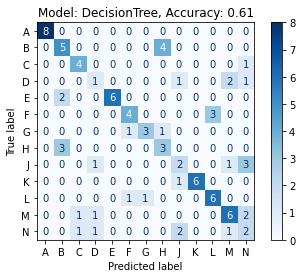

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.50      0.56      0.53         9
           C       0.67      0.80      0.73         5
           D       0.25      0.20      0.22         5
           E       1.00      0.75      0.86         8
           F       0.67      0.57      0.62         7
           G       0.75      0.60      0.67         5
           H       0.38      0.50      0.43         6
           J       0.33      0.29      0.31         7
           K       1.00      0.86      0.92         7
           L       0.67      0.75      0.71         8
           M       0.60      0.60      0.60        10
           N       0.22      0.29      0.25         7

    accuracy                           0.61        92
   macro avg       0.62      0.60      0.60        92
weighted avg       0.63      0.61      0.61        92

FP: 36, FN: 36, avg_FP+FN; 36.0


In [28]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=seed)
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='DecisionTree', seed=seed)
results['DecisionTree'] = res

## Naive Bayes

Accuracy: 0.501 +/- 0.083


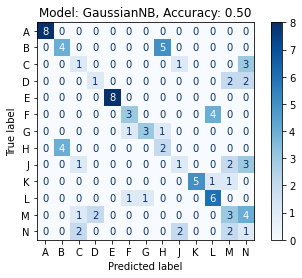

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.50      0.44      0.47         9
           C       0.20      0.20      0.20         5
           D       0.33      0.20      0.25         5
           E       1.00      1.00      1.00         8
           F       0.60      0.43      0.50         7
           G       0.75      0.60      0.67         5
           H       0.25      0.33      0.29         6
           J       0.25      0.14      0.18         7
           K       1.00      0.71      0.83         7
           L       0.55      0.75      0.63         8
           M       0.30      0.30      0.30        10
           N       0.08      0.14      0.10         7

    accuracy                           0.50        92
   macro avg       0.52      0.48      0.49        92
weighted avg       0.54      0.50      0.51        92

FP: 46, FN: 46, avg_FP+FN; 46.0


In [29]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='GaussianNB', seed=seed)
results['GaussianNB'] = res

## KNN

Accuracy: 0.533 +/- 0.083


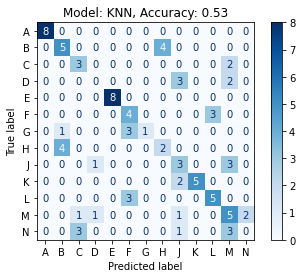

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.50      0.56      0.53         9
           C       0.43      0.60      0.50         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       0.40      0.57      0.47         7
           G       1.00      0.20      0.33         5
           H       0.33      0.33      0.33         6
           J       0.30      0.43      0.35         7
           K       1.00      0.71      0.83         7
           L       0.62      0.62      0.62         8
           M       0.33      0.50      0.40        10
           N       0.00      0.00      0.00         7

    accuracy                           0.53        92
   macro avg       0.53      0.50      0.49        92
weighted avg       0.54      0.53      0.52        92

FP: 43, FN: 43, avg_FP+FN; 43.0


In [30]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='KNN', seed=seed)
results['KNN'] = res

## Random Forest

Accuracy: 0.663 +/- 0.103


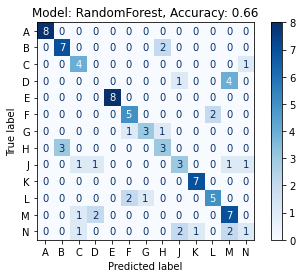

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.70      0.78      0.74         9
           C       0.57      0.80      0.67         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       0.62      0.71      0.67         7
           G       0.75      0.60      0.67         5
           H       0.50      0.50      0.50         6
           J       0.50      0.43      0.46         7
           K       0.88      1.00      0.93         7
           L       0.71      0.62      0.67         8
           M       0.50      0.70      0.58        10
           N       0.33      0.14      0.20         7

    accuracy                           0.66        92
   macro avg       0.62      0.64      0.62        92
weighted avg       0.64      0.66      0.64        92

FP: 31, FN: 31, avg_FP+FN; 31.0


In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=seed)
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='RandomForest', seed=seed)
results['RandomForest'] = res

## LDA

Accuracy: 0.512 +/- 0.122


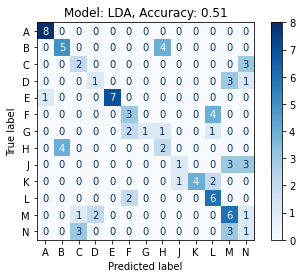

              precision    recall  f1-score   support

           A       0.89      1.00      0.94         8
           B       0.56      0.56      0.56         9
           C       0.33      0.40      0.36         5
           D       0.33      0.20      0.25         5
           E       1.00      0.88      0.93         8
           F       0.43      0.43      0.43         7
           G       1.00      0.20      0.33         5
           H       0.29      0.33      0.31         6
           J       0.50      0.14      0.22         7
           K       1.00      0.57      0.73         7
           L       0.46      0.75      0.57         8
           M       0.40      0.60      0.48        10
           N       0.11      0.14      0.12         7

    accuracy                           0.51        92
   macro avg       0.56      0.48      0.48        92
weighted avg       0.57      0.51      0.51        92

FP: 45, FN: 45, avg_FP+FN; 45.0


In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis()
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='LDA', seed=seed)
results['LDA'] = res

## QDA  

/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/rezachi/opt/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.674 +/- 0.100


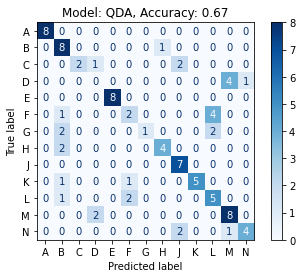

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.53      0.89      0.67         9
           C       1.00      0.40      0.57         5
           D       0.00      0.00      0.00         5
           E       1.00      1.00      1.00         8
           F       0.40      0.29      0.33         7
           G       1.00      0.20      0.33         5
           H       0.80      0.67      0.73         6
           J       0.64      1.00      0.78         7
           K       1.00      0.71      0.83         7
           L       0.45      0.62      0.53         8
           M       0.62      0.80      0.70        10
           N       0.80      0.57      0.67         7

    accuracy                           0.67        92
   macro avg       0.71      0.63      0.63        92
weighted avg       0.71      0.67      0.66        92

FP: 30, FN: 30, avg_FP+FN; 30.0


In [33]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
res = cross_validation(model=clf, X=X_pca, labels=y, label_names= label_names, n_folds=5, model_name='QDA', seed=seed)
results['QDA'] = res

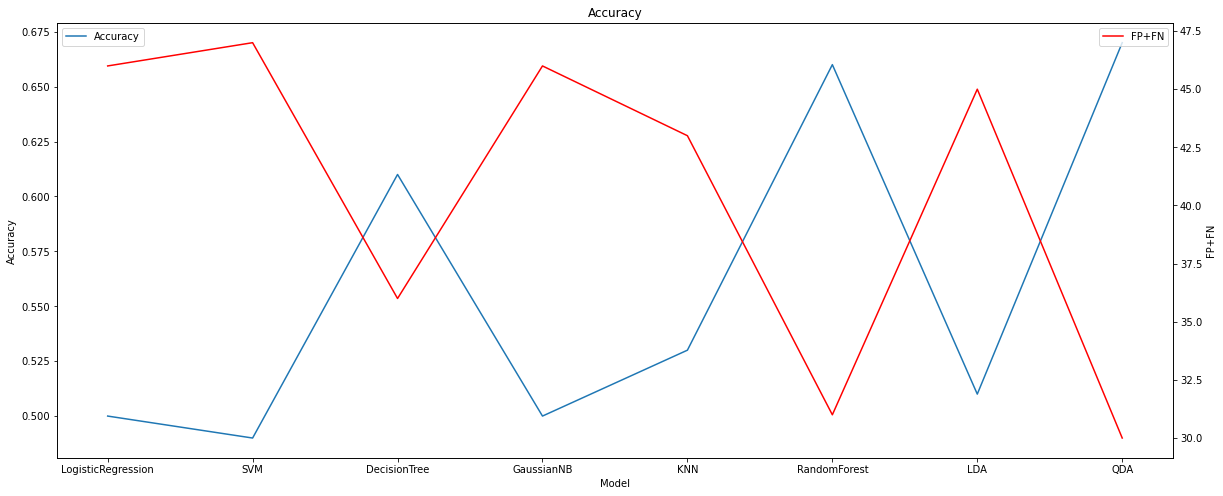

In [34]:
# Plot the results
models = results.keys()
acc = [results[model]['accuracy_score'] for model in models]
avg_fp_fn = [results[model]['avg_FP_FN'] for model in models]

fig, ax = plt.subplots(1, figsize=(20, 8))
ax.plot(models, acc, label='Accuracy')
ax.title.set_text('Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.legend()

ax2 = ax.twinx()
ax2.plot(models, avg_fp_fn, color='red', label='FP+FN')
ax2.set_ylabel('FP+FN')
ax2.legend()

plt.show()

# Decision Function

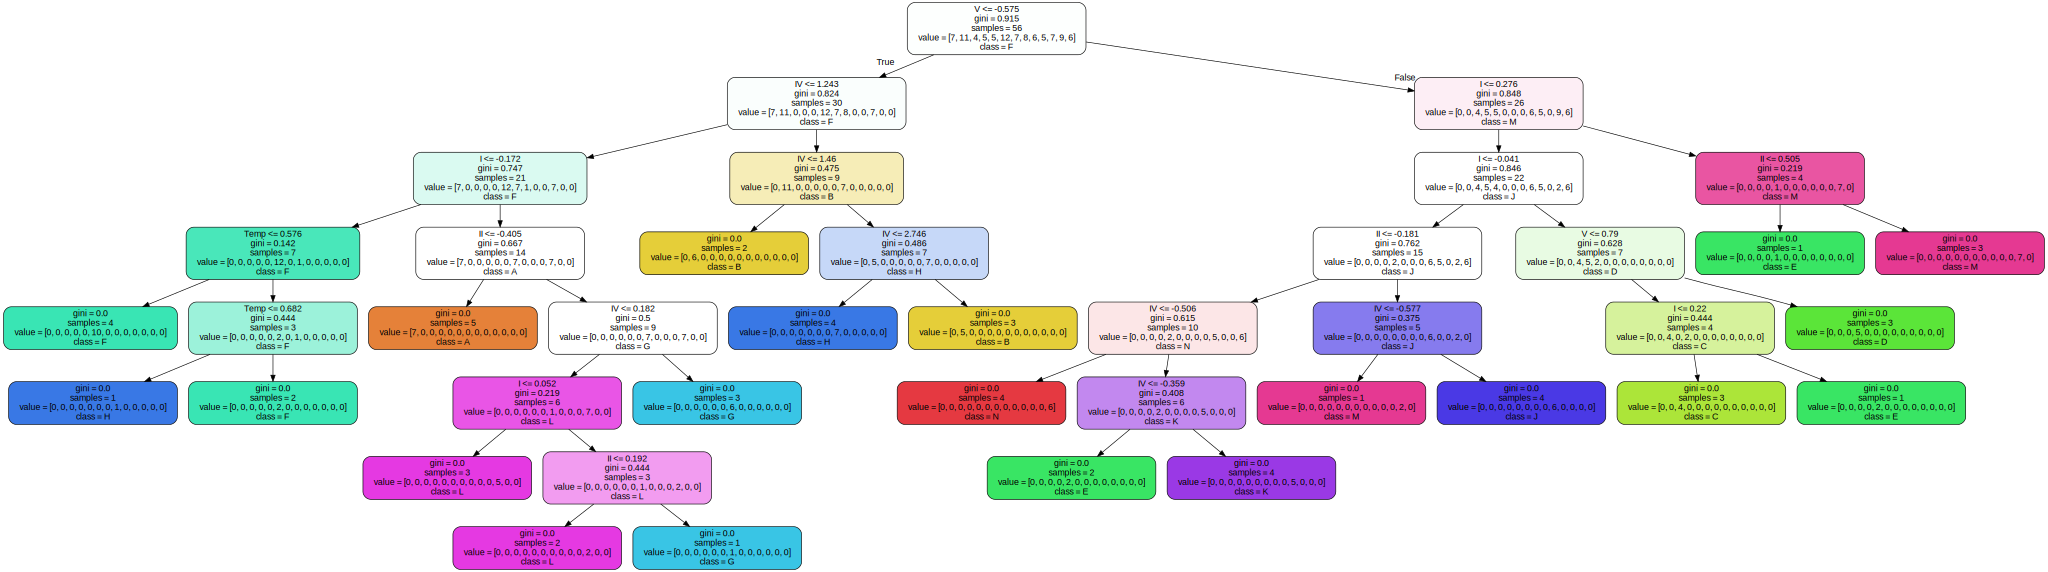

In [55]:
dot_data = export_graphviz(pipeline.steps[1][1].estimators_[0], feature_names=list(features_list), class_names=list(label_names),
          filled=True, impurity=True, rounded=True)

graph = graphviz.Source(dot_data, format='png')
graph

In [70]:
graph.render('decision_function')

'decision_function.png'

In [68]:
with open('./decision_function.txt', 'w') as file:
    file.write(export_text(pipeline.steps[1][1].estimators_[0], 
                  spacing=3, decimals=3,
                  feature_names=list(features_list)))

# Oversampling

## Data Preparation 

In [8]:
over_samples = [train_df]
type_D = train_df[train_df['Impurity.Type'] == 'D']
n_over_samples_D = train_df[train_df['Impurity.Type'] == 'M'].shape[0] - train_df[train_df['Impurity.Type'] == 'D'].shape[0]
type_D_over_sample = type_D.sample(n_over_samples_D, replace=True, random_state=seed)
over_samples.append(type_D_over_sample)

type_H = train_df[train_df['Impurity.Type'] == 'H']
n_over_samples_H = train_df[train_df['Impurity.Type'] == 'B'].shape[0] - train_df[train_df['Impurity.Type'] == 'H'].shape[0]
type_H_over_sample = type_H.sample(n_over_samples_H, replace=True, random_state=seed)
over_samples.append(type_H_over_sample)


train_df_over_sample = pd.concat(over_samples)
features_list = train_df_over_sample.columns[1:]
features_over_sample = train_df_over_sample[features_list]
y_over_sample = train_df_over_sample['Impurity.Type']
le = LabelEncoder()
y_over_sample_encoded = le.fit_transform(y_over_sample)

## Random Forest

Accuracy: 0.820 +/- 0.068


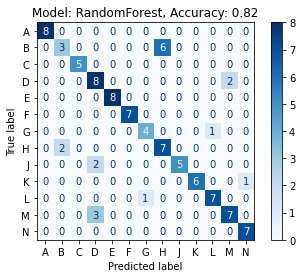

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.60      0.33      0.43         9
           C       1.00      1.00      1.00         5
           D       0.62      0.80      0.70        10
           E       1.00      1.00      1.00         8
           F       1.00      1.00      1.00         7
           G       0.80      0.80      0.80         5
           H       0.54      0.78      0.64         9
           J       1.00      0.71      0.83         7
           K       1.00      0.86      0.92         7
           L       0.88      0.88      0.88         8
           M       0.78      0.70      0.74        10
           N       0.88      1.00      0.93         7

    accuracy                           0.82       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.83      0.82      0.82       100

FP: 18, FN: 18, avg_FP+FN; 18.0


In [9]:
clf = RandomForestClassifier(random_state=seed)
res = cross_validation(model=clf, X=features_over_sample, labels=y_over_sample, label_names= label_names, n_folds=5, model_name='RandomForest', seed=seed)

## Decision Tree

Accuracy: 0.790 +/- 0.058


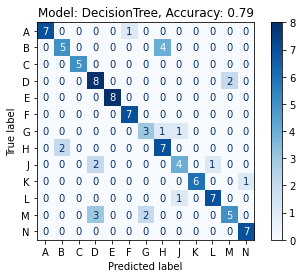

              precision    recall  f1-score   support

           A       1.00      0.88      0.93         8
           B       0.71      0.56      0.63         9
           C       1.00      1.00      1.00         5
           D       0.62      0.80      0.70        10
           E       1.00      1.00      1.00         8
           F       0.88      1.00      0.93         7
           G       0.60      0.60      0.60         5
           H       0.58      0.78      0.67         9
           J       0.67      0.57      0.62         7
           K       1.00      0.86      0.92         7
           L       0.88      0.88      0.88         8
           M       0.71      0.50      0.59        10
           N       0.88      1.00      0.93         7

    accuracy                           0.79       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.80      0.79      0.79       100

FP: 21, FN: 21, avg_FP+FN; 21.0


In [10]:
clf = DecisionTreeClassifier(random_state=seed)
res = cross_validation(model=clf, X=features_over_sample, labels=y_over_sample, label_names= label_names, n_folds=5, model_name='DecisionTree', seed=seed)

## Naive Bayse

Accuracy: 0.750 +/- 0.055


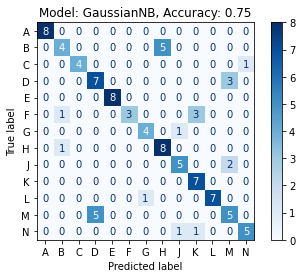

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.67      0.44      0.53         9
           C       1.00      0.80      0.89         5
           D       0.58      0.70      0.64        10
           E       1.00      1.00      1.00         8
           F       1.00      0.43      0.60         7
           G       0.80      0.80      0.80         5
           H       0.62      0.89      0.73         9
           J       0.71      0.71      0.71         7
           K       0.64      1.00      0.78         7
           L       1.00      0.88      0.93         8
           M       0.50      0.50      0.50        10
           N       0.83      0.71      0.77         7

    accuracy                           0.75       100
   macro avg       0.80      0.76      0.76       100
weighted avg       0.78      0.75      0.75       100

FP: 25, FN: 25, avg_FP+FN; 25.0


In [11]:
clf = GaussianNB()
res = cross_validation(model=clf, X=features_over_sample, labels=y_over_sample, label_names= label_names, n_folds=5, model_name='GaussianNB', seed=seed)

## Voting Classifier

Accuracy: 0.850 +/- 0.055


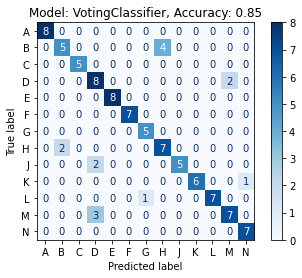

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.71      0.56      0.63         9
           C       1.00      1.00      1.00         5
           D       0.62      0.80      0.70        10
           E       1.00      1.00      1.00         8
           F       1.00      1.00      1.00         7
           G       0.83      1.00      0.91         5
           H       0.64      0.78      0.70         9
           J       1.00      0.71      0.83         7
           K       1.00      0.86      0.92         7
           L       1.00      0.88      0.93         8
           M       0.78      0.70      0.74        10
           N       0.88      1.00      0.93         7

    accuracy                           0.85       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.86      0.85      0.85       100

FP: 15, FN: 15, avg_FP+FN; 15.0


In [12]:
clf1 = RandomForestClassifier(random_state=seed)
clf2 = clf = GaussianNB()
clf3 = DecisionTreeClassifier(random_state=seed)
clf4 = LinearDiscriminantAnalysis()
clf5 = SVC(random_state=seed)
clf = VotingClassifier(estimators=[('RandomForest', clf1)\
                                    ,('NavieBayse', clf2)\
                                    ,('DecisionTree', clf3)\
                                    # ,('LDA', clf4)
                                    # ,('SVM', clf5)
                                    ]\
                                    ,voting='hard')
# clf = clf.set_params(NavieBayse='drop')
res = cross_validation(model=clf, X=features_over_sample, labels=y_over_sample, label_names= label_names, n_folds=5, model_name='VotingClassifier', seed=seed)

# Statistical Significant Test

In [12]:
n_folds = 5
clf1 = RandomForestClassifier(random_state=seed)
cv1 = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
pipeline1 = Pipeline([('scaler', StandardScaler()), ('cv1', clf1)])
scores1 = cross_val_score(pipeline1, features_over_sample, y_over_sample, cv=cv1, scoring='accuracy')

clf2 = GaussianNB()
cv2 = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
pipeline2 = Pipeline([('scaler', StandardScaler()), ('cv2', clf2)])
scores2 = cross_val_score(pipeline2, features_over_sample, y_over_sample, cv=cv2, scoring='accuracy')

clf3 = DecisionTreeClassifier(random_state=seed)
cv3 = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
pipeline3 = Pipeline([('scaler', StandardScaler()), ('cv3', clf3)])
scores3 = cross_val_score(pipeline3, features_over_sample, y_over_sample, cv=cv3, scoring='accuracy')

# fig, ax = plt.subplots(1, figsize=(20, 8))
# ax.hist(scores1, bins=5, alpha=0.5, label='RandomForest')
# ax.hist(scores2, bins=5, alpha=0.5, label='VotingClassifier')
# ax.hist(scores3, bins=5, alpha=0.5, label='GaussianNB')
# ax.title.set_text('Accuracy')
# ax.set_ylabel('Probability')
# ax.set_xlabel('Accuracy')
# ax.legend()

# plt.show()

In [13]:
from mlxtend.evaluate import paired_ttest_5x2cv, paired_ttest_kfold_cv

print('Statistical Test Between RandomForest and GaussianNB')
t, p = paired_ttest_kfold_cv(estimator1=pipeline1, estimator2=pipeline2, X=np.array(features_over_sample), y=np.array(y_over_sample_encoded), random_seed=seed)
print('Paired t-test k-fold')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

# Interpretation
alpha = 0.05
if p <= alpha:
    print('Difference between RandomForest and GaussianNB is statistically significant (reject H0)')
else:
    print('Difference between RandomForest and GaussianNB is not statistically significant (fail to reject H0)')

print('Statistical Test Between RandomForest and DecisionTree')
t, p = paired_ttest_kfold_cv(estimator1=pipeline1, estimator2=pipeline3, X=np.array(features_over_sample), y=np.array(y_over_sample_encoded), random_seed=seed)
print('Paired t-test k-fold')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

# Interpretation
alpha = 0.05
if p <= alpha:
    print('Difference between RandomForest and DecisionTree is statistically significant (reject H0)')
else:
    print('Difference between RandomForest and DecisionTree is not statistically significant (fail to reject H0)')


print('Statistical Test Between GaussianNB and DecisionTree')
t, p = paired_ttest_kfold_cv(estimator1=pipeline2, estimator2=pipeline3, X=np.array(features_over_sample), y=np.array(y_over_sample_encoded), random_seed=seed)
print('Paired t-test k-fold')
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

# Interpretation
alpha = 0.05
if p <= alpha:
    print('Difference between GaussianNB and DecisionTree is statistically significant (reject H0)')
else:
    print('Difference between GaussianNB and DecisionTree is not statistically significant (fail to reject H0)')

Statistical Test Between RandomForest and GaussianNB
Paired t-test k-fold
t statistic: 3.139
p value: 0.012
Difference between RandomForest and GaussianNB is statistically significant (reject H0)
Statistical Test Between RandomForest and DecisionTree
Paired t-test k-fold
t statistic: 0.688
p value: 0.509
Difference between RandomForest and DecisionTree is not statistically significant (fail to reject H0)
Statistical Test Between GaussianNB and DecisionTree
Paired t-test k-fold
t statistic: -3.073
p value: 0.013
Difference between GaussianNB and DecisionTree is statistically significant (reject H0)


# Grid Search and Final Prediction

In [14]:
# grid search for algorithm tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# create pipeline for RandomForest as base classifiers for grid search
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('RandomForest', RandomForestClassifier(random_state=seed)))
pipeline = Pipeline(estimators)

# define the grid search parameters
param_grid = dict(RandomForest__n_estimators=np.array([10, 50, 100, 200]), RandomForest__max_depth=np.array([1, 2, 3, 4, 5]))
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=kfold, verbose=1)
grid_result = grid.fit(features_over_sample, y_over_sample_encoded)

# summarize results
best_score, best_params = grid_result.best_score_, grid_result.best_params_

print('Best: %f using %s' % (best_score, best_params))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best: 0.850000 using {'RandomForest__max_depth': 4, 'RandomForest__n_estimators': 50}


In [82]:
# create pipeline for GausianNB as base classifiers for grid search
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('GaussianNB', GaussianNB()))
pipeline = Pipeline(estimators)

# define the grid search parameters
param_grid = dict(GaussianNB__var_smoothing=np.array([1e-9, 1e-8, 1e-7, 1e-6, 1e-5]))
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=kfold, verbose=1)
grid_result = grid.fit(features_over_sample, y_over_sample_encoded)

# summarize results
best_score, best_params = grid_result.best_score_, grid_result.best_params_

print('Best: %f using %s' % (best_score, best_params))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best: 0.750000 using {'GaussianNB__var_smoothing': 1e-09}


In [84]:
# create pipeline for DecisionTree as base classifiers for grid search
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('DecisionTree', DecisionTreeClassifier(random_state=seed)))
pipeline = Pipeline(estimators)

# define the grid search parameters
param_grid = dict(DecisionTree__criterion=np.array(['gini', 'entropy']), DecisionTree__max_depth=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='accuracy', cv=kfold, verbose=1)
grid_result = grid.fit(features_over_sample, y_over_sample_encoded)

# summarize results
best_score, best_params = grid_result.best_score_, grid_result.best_params_

print('Best: %f using %s' % (best_score, best_params))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best: 0.800000 using {'DecisionTree__criterion': 'entropy', 'DecisionTree__max_depth': 6}


In [15]:
# Make Voting Classifier with the best parameters
clf1 = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=seed)
clf2 = GaussianNB(var_smoothing=1e-09)
clf3 = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=seed)
clf = VotingClassifier(estimators=[('RandomForest', clf1), ('GaussianNB', clf2), ('DecisionTree', clf3)], voting='hard')

# Create pipeline for VotingClassifier
pipeline = Pipeline([('scaler', StandardScaler()), ('cv', clf)])

# Evaluate the model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
scores = cross_val_score(pipeline, features_over_sample, y_over_sample, scoring='accuracy', cv=cv)

# Summarize the result
mean_score, std_score = np.mean(scores), np.std(scores)

print('Accuracy: %.3f (%.3f)' % (mean_score, std_score))

Accuracy: 0.830 (0.081)


Accuracy: 0.830 +/- 0.081


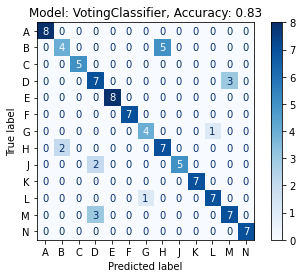

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         8
           B       0.67      0.44      0.53         9
           C       1.00      1.00      1.00         5
           D       0.58      0.70      0.64        10
           E       1.00      1.00      1.00         8
           F       1.00      1.00      1.00         7
           G       0.80      0.80      0.80         5
           H       0.58      0.78      0.67         9
           J       1.00      0.71      0.83         7
           K       1.00      1.00      1.00         7
           L       0.88      0.88      0.88         8
           M       0.70      0.70      0.70        10
           N       1.00      1.00      1.00         7

    accuracy                           0.83       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.84      0.83      0.83       100

FP: 17, FN: 17, avg_FP+FN; 17.0


In [16]:
clf1 = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=seed)
clf2 = GaussianNB(var_smoothing=1e-09)
clf3 = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=seed)
clf = VotingClassifier(estimators=[('RandomForest', clf1), ('GaussianNB', clf2), ('DecisionTree', clf3)], voting='hard')

res = cross_validation(model=clf, X=features_over_sample, labels=y_over_sample, label_names= label_names, n_folds=5, model_name='VotingClassifier', seed=seed)

In [17]:
# Predict the test data
pipeline.fit(features_over_sample, y_over_sample)
y_pred = pipeline.predict(test_df)

y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
y_pred.to_csv('chemical_predictions_group_X_week_Y.csv', index=False, header=False)

# Notes

In [ ]:
# TODO
# check how the best model is working with features. e.g. feature_importances_ in Random Forest
